# Distillation of Robust Models via the Convex Outer Adversarial Polytope - CIFAR-10 Dataset

In this notebook, two state-of-the-art CNNs of 4 convolutional layers prior to the fully-connected part (trained on the CIFAR-10 normally and robustly using the the "Convex Outer Adversarial Polytope" described in [Provable Defenses against Adversarial Examples via the Convex Outer Adversarial Polytope](https://arxiv.org/pdf/1711.00851.pdf) by Wong and Kolter) are distillated to shallow neural networks.

The distillated models have been generated using one of the following techniques:

*   "Matching the Logits" as it is described by Ba & Caruana on [Do Deep Nets Really Need to be Deep?](https://arxiv.org/pdf/1312.6184.pdf)

## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install cleverhans

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat

## Define The Model Architectures

### CNN Network 

In [ ]:
def get_CNN_model():
  #CNN network for classification
  cifar_model = models.Sequential(name='CNN')
  cifar_model.add(layers.Conv2D(32, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  cifar_model.add(layers.Conv2D(32, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  cifar_model.add(layers.Conv2D(64, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='4'))
  cifar_model.add(layers.Conv2D(64, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='6'))
  cifar_model.add(Flatten(name='8'))
  cifar_model.add(layers.Dense(512, activation='relu', name='9'))
  cifar_model.add(layers.Dense(10, name='11'))
  return cifar_model

### Shallow CNN Network (S-CNN) with 2 Convolutional Layers

In [ ]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #CNN network for classification
  cifar_model = models.Sequential(name='SCNN')
  cifar_model.add(layers.Conv2D(channels_l1, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  cifar_model.add(layers.Conv2D(channels_l2, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  cifar_model.add(Flatten(name='8'))
  cifar_model.add(layers.Dense(512, activation='relu', name='9'))
  cifar_model.add(layers.Dense(10, name="logit"))
  cifar_model.add(layers.Activation('softmax'))
  return cifar_model

## Load Dataset and Preprocessing

In [ ]:
# Restore the data
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

# Change for converted from PyTorch model
x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
# Restore the labels
y_labels_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_train.npy')
y_labels_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_test.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')
y_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_train.npy')
y_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_test.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_acc_test.npy')

## Training 

### CNN

In [ ]:
#Train CNN
def train_cnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_CNN_model()
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
svhn_model.summary()

In [ ]:
svhn_model = train_cnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('CNN_SVHN.h5')
print ('Model Saved')

### SCNN

In [ ]:
#Train SCNN
def train_scnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=4, channels_l2=8)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
#Save trained SCNN model
svhn_model = train_scnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('SCNN_SVHN.h5')
print ('Model Saved')

## Accuracy Evaluation on the Test Set

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

In [ ]:
# Evaluate CNN
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras.h5')
score, acc = svhn_model.evaluate(x, keras.utils.to_categorical(y, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
svhn_model = get_SCNN_model_layer2(channels_l1=4, channels_l2=8)
svhn_model = keras.models.load_model('/content/SCNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, keras.utils.to_categorical(y_labels_acc_test, num_classes=10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

## CNN Model Distillation - Shallow CNNs

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(svhn_model, x_train, x_test):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('11').output)
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(svhn_model, name):

  # Normal probabilities from logits before softmax activation
  logits = svhn_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  svhn_model = Model(svhn_model.input, output, name=name)
  
  return svhn_model

### Training / Evaluation and Attacks for 2 Layers


#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_train_cnn_extra_cifar.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_test_cnn_extra_cifar.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/cifar_data/y_labels_acc_test.npy')

x_test_cnn_extra = x_test_cnn_extra.transpose(0, 3, 1, 2)
x_train_cnn_extra = x_train_cnn_extra.transpose(0, 3, 1, 2)
x_test_cnn = x_test_cnn.transpose(0, 3, 1, 2)
x_train_cnn = x_train_cnn.transpose(0, 3, 1, 2)
x_acc_test_cnn = x_acc_test_cnn.transpose(0, 3, 1, 2)

#### Training

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [4, 16, 16] 
channels_to_test2 = [8, 32, 64] 

index_for_two = 0;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/Robust_Keras_CIFAR_7.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn_extra, x_test_cnn_extra)
  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_logits, x_test_cnn_extra, test_logits)

  # Learning Curves Data
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/10000.0
  print ("Test Accuracy: %.5f" % score)
  scores_2_layer.append(score)
  channels_number.append(channel)

  index_for_two = index_for_two + 1

  print ('----------------------------')

#### Results

##### Learning Curves for Extra Data - Baseline


In [ ]:
loss_train_4_8= [3.338364954249064, 2.00112668194241, 1.6187075660281711, 1.4204730332480537, 1.2866503380245633, 1.1857416562080383, 1.1076067946539985, 1.0507420406977335, 0.9968432813538446, 0.9545161578284369, 0.9207712675836351, 0.8914346624586317, 0.8662795826382107, 0.8453782072491116, 0.8278237903277079, 0.8033388248443604, 0.7851633351008097, 0.7726057308091058, 0.7563044081581963, 0.7475662190649245, 0.7320781116485595, 0.7211876495361328, 0.710397877269321, 0.7012875729242961, 0.6915277394400703, 0.6790849136246575, 0.6743978904088338, 0.66530927350786, 0.6581698636478848, 0.6523993919796414, 0.6431660689353943, 0.6369936208724976, 0.6305218355072869, 0.626996288034651, 0.6192295177141826, 0.6140893583509657, 0.6093144402080112, 0.6059851692305671, 0.601177670372857, 0.5961370340400272, 0.5898185089959038, 0.5848290938059489, 0.5816800053384569, 0.5805561194737753, 0.5752647127575344]
loss_test_4_8= [2.3154606380462646, 1.7746399019241332, 1.6434425075531005, 1.4043449447631835, 1.3465475700378418, 1.2128522521972656, 1.1588158765792846, 1.12765625, 1.1139355152130126, 1.0889114543914795, 1.040604019355774, 1.0749786693572998, 1.0169696398735046, 1.013319448375702, 0.9973080581665039, 1.006599390411377, 0.9723217755317688, 1.0309292171478273, 0.9696295360565186, 0.9766734479904174, 1.005627200126648, 0.983792357635498, 0.98509872341156, 1.008001713848114, 0.9642206459999084, 0.973513565826416, 0.9679767919540405, 0.9855322717666626, 0.9702129167556762, 0.9982282466888428, 0.9884150010108947, 1.0074111400604249, 1.005615643119812, 0.9831060676574707, 0.981559346485138, 1.005238528060913, 0.9839823661804199, 0.9841242764472962, 0.9892417022705078, 0.9891307470321655, 0.9997367667198181, 0.9976360269546509, 1.0085071355819701, 0.9882024446487426, 1.081898717880249]
acc_train_4_8= [0.40134445, 0.53022224, 0.5717889, 0.59735554, 0.61517775, 0.6290333, 0.6412111, 0.6481778, 0.6568556, 0.6647556, 0.6687, 0.67325556, 0.6774, 0.6790111, 0.68306667, 0.6861889, 0.6893778, 0.69045556, 0.6911778, 0.69347775, 0.6955778, 0.6979, 0.6987, 0.7010889, 0.70408887, 0.7038111, 0.7048111, 0.70676666, 0.7076, 0.7080778, 0.7104667, 0.7115, 0.7113111, 0.7123111, 0.7121222, 0.7135556, 0.7156111, 0.7157, 0.71716666, 0.7159333, 0.7183, 0.71886665, 0.71855557, 0.7188333, 0.7190222]
acc_test_4_8= [0.49825000762939453, 0.5616999864578247, 0.583299994468689, 0.60589998960495, 0.6150000095367432, 0.6277499794960022, 0.6392999887466431, 0.6449999809265137, 0.6485499739646912, 0.6561499834060669, 0.6559500098228455, 0.6570000052452087, 0.6642500162124634, 0.6633999943733215, 0.6649500131607056, 0.663100004196167, 0.6715499758720398, 0.6523500084877014, 0.6705999970436096, 0.6712999939918518, 0.664900004863739, 0.6643999814987183, 0.6723999977111816, 0.6686000227928162, 0.6734499931335449, 0.6726499795913696, 0.6729999780654907, 0.6714500188827515, 0.6721500158309937, 0.6621500253677368, 0.6696500182151794, 0.667900025844574, 0.6721500158309937, 0.6717000007629395, 0.6765999794006348, 0.6669999957084656, 0.6703500151634216, 0.6710500121116638, 0.671750009059906, 0.6707500219345093, 0.6703500151634216, 0.6694499850273132, 0.6672499775886536, 0.6691499948501587, 0.6632999777793884]

loss_train_16_32=[2.17829656768375, 1.0868009429719714, 0.8420553982204861, 0.7182091014650133, 0.6416274208280776, 0.5862873334354824, 0.5416708941141765, 0.5070705505212149, 0.47714803847206966, 0.44998846821255156, 0.4252481498082479, 0.4056738581127591, 0.3867558510409461, 0.36971972539689807, 0.35584409077962237, 0.339435082271364, 0.3268704210705227, 0.3168946405622694, 0.304398314915763, 0.29672687362300026, 0.28606400677363075, 0.276670516705513, 0.26860790609783597, 0.26087171948750815, 0.2545056664943695, 0.24855002433988782, 0.24071400847434998, 0.235703418191274, 0.230394861931271, 0.22582195240656536, 0.2198642433166504, 0.2154100557618671]
loss_test_16_32=[1.4880987586975098, 0.9393680938720703, 0.810624361038208, 0.7241550486564636, 0.699237252998352, 0.7312022850990295, 0.6187620885848999, 0.6458841039657592, 0.603273436832428, 0.645086346244812, 0.5697378779411316, 0.5992224536895752, 0.5722277959823608, 0.5530956666946412, 0.5713545958518982, 0.5553671745300293, 0.5791382360458374, 0.5629302368164063, 0.5689275188446045, 0.5532116180419921, 0.5622436504364013, 0.555153588962555, 0.5961214557647705, 0.5818433229446411, 0.6137174304008484, 0.5728385689735412, 0.5854971483230591, 0.594839759349823, 0.5858066461563111, 0.5686227558135987, 0.5862519567489624, 0.5820028631210327]
acc_train_16_32=[0.5084444, 0.6438111, 0.6848222, 0.7087333, 0.72316664, 0.73516667, 0.7435333, 0.74876666, 0.7558778, 0.76096666, 0.76746666, 0.7708222, 0.7753556, 0.77977777, 0.7820445, 0.7860778, 0.78892225, 0.7900889, 0.79572225, 0.79667777, 0.8003111, 0.80285555, 0.8028, 0.8068333, 0.8087, 0.80955553, 0.81256664, 0.8138111, 0.81508887, 0.8156889, 0.8180778, 0.8203222]
acc_test_16_32=[0.6147000193595886, 0.6717000007629395, 0.7008000016212463, 0.7135000228881836, 0.7245000004768372, 0.7158499956130981, 0.7376999855041504, 0.7330999970436096, 0.7356500029563904, 0.7368000149726868, 0.7462999820709229, 0.7444999814033508, 0.7458999752998352, 0.7476500272750854, 0.7423999905586243, 0.7484999895095825, 0.749750018119812, 0.748449981212616, 0.7487499713897705, 0.7504500150680542, 0.7512999773025513, 0.7527999877929688, 0.7458000183105469, 0.7512999773025513, 0.7471500039100647, 0.7522000074386597, 0.7491499781608582, 0.7438499927520752, 0.7443000078201294, 0.7477499842643738, 0.7479000091552734, 0.7502999901771545]

loss_train_16_64=[2.152672468164232, 1.0232002502017552, 0.7763474402957492, 0.650040464507209, 0.5709974129147, 0.5107311204963261, 0.4622052537812127, 0.42385552693472967, 0.3902886588361528, 0.3649957525147332, 0.3370829229619768, 0.3167145685619778, 0.2969321705871158, 0.2767856953303019, 0.261395512008667, 0.24762432254685296, 0.23516318363878463, 0.22342935262521108, 0.21122004832426708, 0.20145832272635567, 0.19127883168856302, 0.1835529960208469, 0.17771117163234287, 0.1706632842540741]
loss_test_16_64=[1.2549918899536132, 0.8969083585739136, 0.7931030355453491, 0.6743661919593811, 0.676554266166687, 0.6443735434532165, 0.572339277267456, 0.5941469352722168, 0.5476474700927735, 0.554406686592102, 0.5399884798049926, 0.5534898484230042, 0.54007989859581, 0.5376580894470215, 0.5561206436157227, 0.5451383714199066, 0.5827019681453705, 0.5649838490009308, 0.576350565624237, 0.5501748339653015, 0.5564502301216125, 0.5663383082389831, 0.567093182182312, 0.5844187755107879]
acc_train_16_64=[0.51185554, 0.65401113, 0.6974889, 0.7206445, 0.7354889, 0.74917775, 0.75906664, 0.7668222, 0.7752333, 0.7818889, 0.7885, 0.7923333, 0.79653335, 0.80204445, 0.80785555, 0.8108, 0.81516665, 0.8183, 0.8234444, 0.826, 0.82997775, 0.8325, 0.8351, 0.83793336]
acc_test_16_64=[0.628600001335144, 0.6800500154495239, 0.6997500061988831, 0.7208999991416931, 0.7285000085830688, 0.7301999926567078, 0.7436500191688538, 0.7382500171661377, 0.7510499954223633, 0.7514500021934509, 0.7498999834060669, 0.7500500082969666, 0.7521499991416931, 0.7530999779701233, 0.7522500157356262, 0.7526000142097473, 0.7508999705314636, 0.7494500279426575, 0.7504000067710876, 0.7496500015258789, 0.7517499923706055, 0.7462000250816345, 0.7491499781608582, 0.7446500062942505]

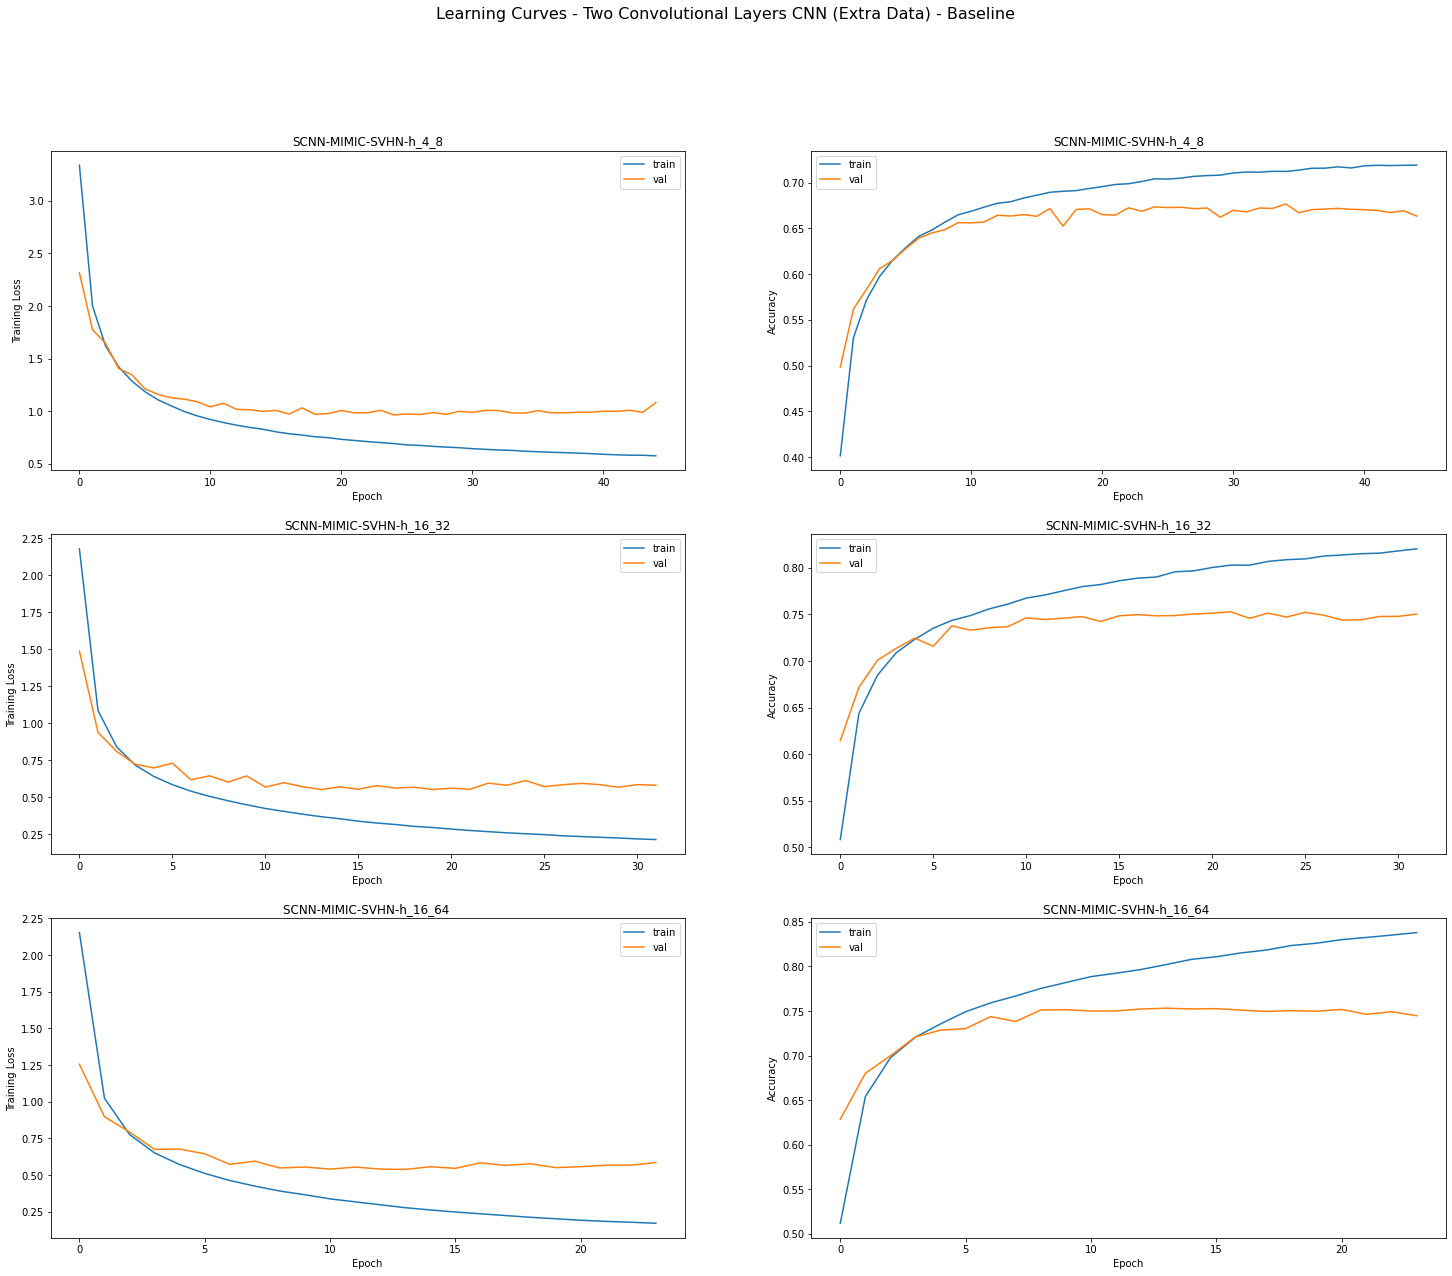

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Baseline', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(3, 2, 1)
plt.plot(loss_train_4_8, label='train');
plt.plot(loss_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 2)
plt.plot(acc_train_4_8, label='train');
plt.plot(acc_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(3, 2, 3)
plt.plot(loss_train_16_32, label='train');
plt.plot(loss_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 4)
plt.plot(acc_train_16_32, label='train');
plt.plot(acc_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(3, 2, 5)
plt.plot(loss_train_16_64 , label='train');
plt.plot(loss_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 6)
plt.plot(acc_train_16_64 , label='train');
plt.plot(acc_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Robust


In [ ]:
loss_train_4_8=[0.9447901705847846, 0.47165100270377264, 0.3616207781738705, 0.3041360020690494, 0.26651569687525434, 0.23988154419793023, 0.21838049164877998, 0.20252596242692736, 0.18914317391713462, 0.179335148885515, 0.17048831176227994, 0.16507425884935592, 0.15765340613126755, 0.153410246096717, 0.1497336580965254, 0.14416639532777997, 0.1423922356393602, 0.13830650075276693, 0.1363811550087399, 0.13220965155098174, 0.1287664275407791, 0.12824714148044586, 0.12534971156650118, 0.12260566692087385, 0.1209968508190579, 0.11904856570031908, 0.11851205136511062, 0.11684650591876772, 0.11551823199590047, 0.11334320492744446, 0.11207788823180728, 0.11115050371487935, 0.10909792527887556, 0.10883333139684465, 0.10720133660899268, 0.1063488036553065, 0.10581468583080504, 0.10391597919464111, 0.10410702385902405, 0.10255296645429399, 0.10126869684590234, 0.10038074884414673, 0.10028695327970717, 0.09930289800034629, 0.09880490760538313, 0.0976093854493565, 0.09681357253392538, 0.09644301929208968, 0.09565238348378076, 0.09593528940942553]
loss_test_4_8=[0.5586247597694397, 0.43023476934432986, 0.3355794665336609, 0.31820726313591, 0.2634292011737823, 0.24206300444602966, 0.23176044099330903, 0.21465532355308534, 0.204948548078537, 0.19414226350784303, 0.19289162781238556, 0.19252080738544464, 0.19128255467414856, 0.19971878969669343, 0.17658122181892394, 0.17418361811637878, 0.19902446417808534, 0.17603078622817994, 0.1680698492527008, 0.16791896829605102, 0.16692995047569276, 0.17214506514072417, 0.17349218940734865, 0.17774342527389525, 0.1744072648525238, 0.16459098341464995, 0.16551076669692993, 0.1670266782283783, 0.16813790993690492, 0.1632176540374756, 0.1620137752056122, 0.17228147602081298, 0.16667855343818663, 0.169046715259552, 0.16663820595741272, 0.1639752846956253, 0.16629987506866456, 0.1677717824459076, 0.16065797348022462, 0.16037520651817322, 0.1607969648361206, 0.16122185850143433, 0.16149205999374389, 0.1591919288635254, 0.166319473361969, 0.1595842358827591, 0.16815356872081758, 0.17709691619873047, 0.16081115918159486, 0.16449230799674988]
acc_train_4_8=[0.5111222, 0.64894444, 0.6918778, 0.7161667, 0.73145556, 0.74432224, 0.7542667, 0.76294446, 0.7692111, 0.7754111, 0.7799444, 0.7825111, 0.7863889, 0.79098886, 0.7905333, 0.79314446, 0.7953111, 0.79833335, 0.7992, 0.8018444, 0.80286664, 0.8039889, 0.8058222, 0.8074, 0.80671114, 0.8095, 0.8100333, 0.8107, 0.8120222, 0.81413335, 0.81288886, 0.8137222, 0.8153, 0.8163, 0.81648886, 0.8172333, 0.8185889, 0.8185222, 0.8186333, 0.81994444, 0.82063335, 0.8219, 0.82174444, 0.8225222, 0.8205889, 0.8237778, 0.8241444, 0.82305557, 0.82395554, 0.8255444]
acc_test_4_8=[0.6251999735832214, 0.6715499758720398, 0.7060999870300293, 0.7149500250816345, 0.7390499711036682, 0.7426000237464905, 0.7488499879837036, 0.7644000053405762, 0.7698000073432922, 0.7649999856948853, 0.7734500169754028, 0.7791000008583069, 0.779449999332428, 0.7784500122070312, 0.7820500135421753, 0.7854499816894531, 0.7721999883651733, 0.784850001335144, 0.7889000177383423, 0.791700005531311, 0.7868499755859375, 0.7908499836921692, 0.7882000207901001, 0.7867000102996826, 0.7899500131607056, 0.7890999913215637, 0.7926499843597412, 0.7907000184059143, 0.7889999747276306, 0.7968000173568726, 0.7924000024795532, 0.7894999980926514, 0.79339998960495, 0.7882999777793884, 0.7943500280380249, 0.7940999865531921, 0.7925999760627747, 0.791450023651123, 0.7947999835014343, 0.7973999977111816, 0.7936999797821045, 0.7965999841690063, 0.7921500205993652, 0.796500027179718, 0.7922999858856201, 0.7963500022888184, 0.7930499911308289, 0.7864999771118164, 0.7950000166893005, 0.7940999865531921]

loss_train_16_32=[0.5477398610009088, 0.2244014071914885, 0.16718046950499216, 0.13824988685713874, 0.12151005412737528, 0.11013252484533521, 0.09995614275402492, 0.09348456837733586, 0.0865131504535675, 0.08102761019203399, 0.07725575165086322, 0.07173379467858208, 0.06879943731096055, 0.06517332903676563, 0.06303576524655025, 0.060341031302346124, 0.05842487719125218, 0.05589456096622679, 0.054015734481811524, 0.052878015004263985, 0.050694229775004915, 0.048918515529897476, 0.04759792540272077, 0.04659908551110162, 0.04539338572820028, 0.043792164091269174, 0.04302918673753738, 0.04202221933139695, 0.04129839719136556, 0.040347403239541585, 0.03955234650373459, 0.03880975246495671, 0.03782936159604126]
loss_test_16_32=[0.30517085256576537, 0.18993198778629303, 0.15700709475278854, 0.14803171590566636, 0.12582880358695983, 0.1190427286863327, 0.11874596928358078, 0.1073460895895958, 0.10707403475046158, 0.10767829020023346, 0.10294637084007263, 0.1013003450870514, 0.0967079155921936, 0.10620463454723358, 0.11246799199581146, 0.10322996623516083, 0.09562178528308868, 0.09736583312749862, 0.11548020170927048, 0.10510121023654938, 0.09266940371990204, 0.09567546653747559, 0.09694698143005372, 0.10235592247247696, 0.10218053927421569, 0.100235657954216, 0.0975517682313919, 0.09968956562280655, 0.09685894613265991, 0.10131306035518646, 0.0996580178976059, 0.09560708307027817, 0.09896354591846467]
acc_train_16_32=[0.6288889, 0.75652224, 0.78544444, 0.8047111, 0.81523335, 0.8225667, 0.8292111, 0.8353, 0.8404111, 0.8441111, 0.8476889, 0.85165554, 0.85525554, 0.8581111, 0.86072224, 0.8632333, 0.8637111, 0.8664111, 0.8663667, 0.86943334, 0.8705, 0.8732, 0.8745222, 0.8747444, 0.87667775, 0.8778222, 0.8786111, 0.88053334, 0.8802222, 0.88262224, 0.8827556, 0.88296664, 0.8847]
acc_test_16_32=[0.7243000268936157, 0.7738999724388123, 0.7975500226020813, 0.8045499920845032, 0.8165000081062317, 0.8245499730110168, 0.8202499747276306, 0.8281499743461609, 0.8345500230789185, 0.8256000280380249, 0.8393999934196472, 0.8339499831199646, 0.840499997138977, 0.8371000289916992, 0.8362500071525574, 0.8395000100135803, 0.8417999744415283, 0.8443999886512756, 0.8328999876976013, 0.8336499929428101, 0.8449500203132629, 0.8441500067710876, 0.8450999855995178, 0.8339499831199646, 0.8421499729156494, 0.8408499956130981, 0.8445500135421753, 0.8447999954223633, 0.843500018119812, 0.8399999737739563, 0.8346999883651733, 0.8403000235557556, 0.836650013923645]

loss_train_16_64=[0.5348351502365536, 0.2157643298652437, 0.15780700012577906, 0.12916764323446486, 0.11116197797457378, 0.09933594672812356, 0.08980602798726824, 0.08233775000307295, 0.07616181446446313, 0.07147678043577406, 0.0665015708261066, 0.06196264717380206, 0.05767771218220393, 0.05493013065126207, 0.05185963769886229, 0.04975515309439765, 0.046931253127919306, 0.0442704765856266, 0.04294361820684539, 0.0406970537185669, 0.03911040397750007, 0.03791390297545327, 0.03674452041387558, 0.03512817939122518, 0.034257383435964586, 0.033232571087612045, 0.03190932901038064, 0.031053665082322227, 0.03013572401073244, 0.028991110257969962]
loss_test_16_64=[0.2659389634609222, 0.20614769916534423, 0.15104625091552734, 0.13633388640880584, 0.12310706261396408, 0.12691433922052384, 0.11203655788898469, 0.10644157409667969, 0.10674520214796067, 0.10081698775291442, 0.10120766134262085, 0.10074529445171357, 0.09535366418361664, 0.10404957423210144, 0.10083232958316803, 0.09904788088798523, 0.10903417143821716, 0.09532224321365357, 0.10091435502767562, 0.09398093705177307, 0.10031766437292099, 0.09940681364536286, 0.09406398762464524, 0.09786968766450882, 0.09846392376422881, 0.09553067719936371, 0.09674748888015747, 0.10117100847959519, 0.09656437890529633, 0.09607062050104141]
acc_train_16_64=[0.64155555, 0.7638889, 0.7961444, 0.81135553, 0.82467777, 0.83276665, 0.83982223, 0.84437776, 0.84934443, 0.85454446, 0.8567, 0.86105555, 0.8645778, 0.86642224, 0.86962223, 0.8723222, 0.87563336, 0.8795556, 0.88082224, 0.8821667, 0.88505554, 0.886, 0.8878555, 0.8893778, 0.8896889, 0.89195555, 0.8940222, 0.89493334, 0.89662224, 0.89784443]
acc_test_16_64=[0.7437999844551086, 0.7752000093460083, 0.8018500208854675, 0.807449996471405, 0.8141000270843506, 0.8236500024795532, 0.8300999999046326, 0.8328499794006348, 0.8327500224113464, 0.8361999988555908, 0.8378000259399414, 0.8335000276565552, 0.842199981212616, 0.8354499936103821, 0.8383499979972839, 0.838450014591217, 0.8326500058174133, 0.8414999842643738, 0.8374500274658203, 0.8443499803543091, 0.8411499857902527, 0.8399999737739563, 0.8424999713897705, 0.840749979019165, 0.8370000123977661, 0.8406000137329102, 0.8406500220298767, 0.8345000147819519, 0.8406000137329102, 0.8387500047683716]


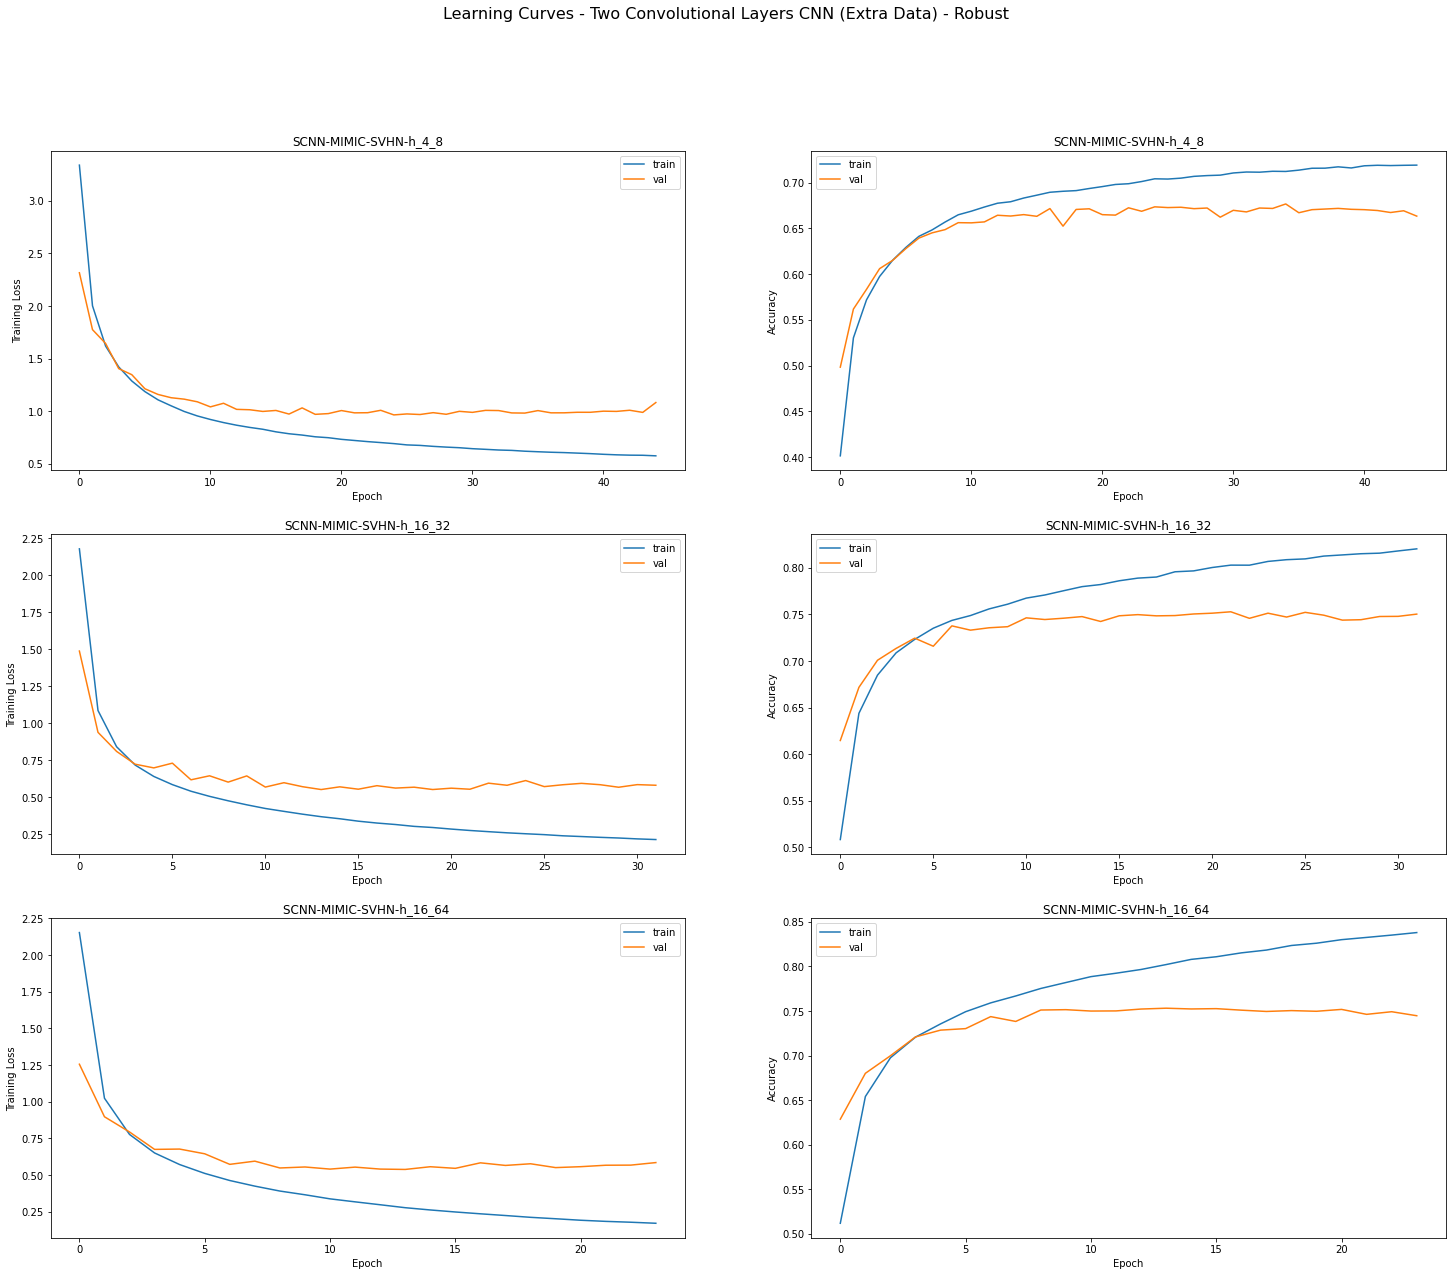

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Robust', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(3, 2, 1)
plt.plot(loss_train_4_8, label='train');
plt.plot(loss_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 2)
plt.plot(acc_train_4_8, label='train');
plt.plot(acc_test_4_8, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_4_8')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(3, 2, 3)
plt.plot(loss_train_16_32, label='train');
plt.plot(loss_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 4)
plt.plot(acc_train_16_32, label='train');
plt.plot(acc_test_16_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(3, 2, 5)
plt.plot(loss_train_16_64 , label='train');
plt.plot(loss_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(3, 2, 6)
plt.plot(acc_train_16_64 , label='train');
plt.plot(acc_test_16_64 , label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h_16_64 ')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');